
1. Simulate some panel data. We’ll do some analysis similar to the Eclipse Bug Report paper, https://arxiv.org/pdf/1803.04129.pdf, but without the DID piece. Specifically,
  * Simulate N units over T discrete time steps.
  * Add confounding through a variable Z  between treated and untreated units which is constant over time. That is, $Z = Z_i$, and not $Z_{it}$ (where $i$ is an index that runs over units, and $t$ runs over time steps). In particular ...
  * Add a time-varying causal state where $D^*$ (as we defined it in class) is caused by $Z_i$. It should be a binary treatment which turns on and stays on for each test unit ($D^* = 1$) at a different time, but never turns on for control units ($D^* = 0$)
  * Compute counterfactuals $Y^0_{it}$ and $Y^1_{it}$ which are caused by $Z_i$.
2. Use your counterfactuals to estimate the time series causal effect. Plot it, and explain from the data generating process why it's correct.
3. Create a propensity score model for $D*$.
4. Match units to estimate the ATT.
5. Estimate the expected counterfactuals for the test group: $E[Y^1_t |D=1]$ and $E[Y^0_t |D=1]$. You’ll have to be careful: since all the units treatments don’t turn on at the same time, you’ll want to mask out the treatment units in the $D_{it}=0$ state when you’re taking your averages. Numpy’s masked array object can be useful here, numpy.ma.array
6. Use the time series you estimated in (4) to estimate the time-varying ATT.


In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

Question 1

In [2]:
units = 5000 #N
time_steps = 52 #T

p_z = .5
z = np.random.binomial(1, p_z, size=units) #Z

p_d = .25 + z / 2
d = np.random.binomial(1, p_d, size=units) #Causal state

start = np.random.randint(1, 52, size=units) #Start time for causal state
delta = 5 #Treatment effect

#N x T array of causal state over time D_it which stays on for treatment and never activates for control
d_it = np.array([[0] * (start[index]) + [delta] * (52 - start[index]) for index, treatment in enumerate(d)])

# taken from matrix_completion.ipynb
a_trend = np.arange(0, time_steps, 1)
Z1 = np.random.normal(size=units)
A_trend = np.tile(a_trend, units).reshape(units, time_steps)
A_indiv = np.tile(Z1, time_steps).reshape(time_steps, units).T
Y_0 = A_trend + A_indiv #Y_0

Y_1 = A_trend + A_indiv + d_it #Y_1

Y = [Y_0[i] if d[i] == 0 else Y_1[i] for i in range(len(d))] #Y_0 if d == 0 ow Y_1

df = pd.DataFrame(Y)
df['d'] = d
df['Z'] = z
df['start'] = start

Question 2

How am I measuring the potential outcomes?  
Average y_it at each time step, I suppose  

In [3]:
df_y0 = pd.DataFrame(Y_0)
df_y1 = pd.DataFrame(Y_1)

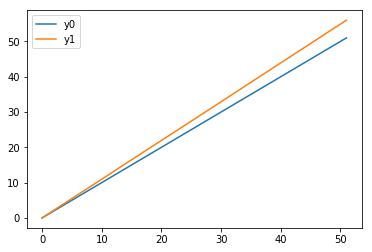

In [4]:
pd.DataFrame({'y0': df_y0.mean(), 'y1': df_y1.mean()}).plot()

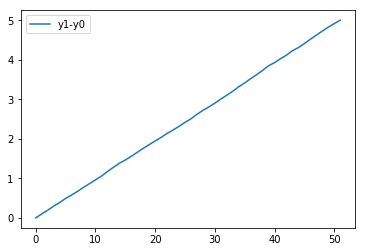

In [5]:
pd.DataFrame({'y1-y0': df_y1.mean() - df_y0.mean()}).plot()

At time $T=52$ the difference in $Y_1$ and $Y_0$ is given by:

In [6]:
df_y1.mean()[51] - df_y0.mean()[51]

5.000000000000021

The data generating process adds a constant delta = 5 to the treatment group, beginning at a variable start time and continuing until T = 52. As expected the difference in the potential outcomes $Y_0, Y_1$ after T time steps is equal to that delta.

Question 3

In [7]:
from statsmodels.api import WLS, OLS
from sklearn.linear_model import LogisticRegression

In [8]:
var_list = [i for i in range(51)]

In [9]:
propensity_model = LogisticRegression(C=1e12)
propensity_model = propensity_model.fit(df[var_list], df['d'])
df['P_d1_t'] = propensity_model.predict_proba(df[var_list])[:, 1]

Question 4

$w_{i, ATT} = \frac{p_i}{1 - p_i}$ if $d_i = 0$, 1 if $d_i = 1$

In [10]:
df['wATT'] = (df['d'] == 1) * 1 + (df['d'] == 0) * df['P_d1_t'] / (1 - df['P_d1_t'])

coef_d = ATT = 4.74?

In [11]:
df['intercept'] = 1
model = WLS(df[51], df[['d', 'intercept']], weights=df['wATT'])
result = model.fit(cov_type='HC3')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     51   R-squared:                       0.332
Model:                            WLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                 3.131e+04
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        18:13:40   Log-Likelihood:                -10295.
No. Observations:                5000   AIC:                         2.059e+04
Df Residuals:                    4998   BIC:                         2.061e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d              5.0332      0.028    176.940      0.000       4.977       5.089
intercept     50.9786      0.020   2530.211      0.000      50.939      51.018
==============================================================================
Omnibus:                      433.501   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2713.120
Skew:                          -0.114   Prob(JB):                         0.00
Kurtosis:                       6.602   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Question 5

Estimate the expected counterfactuals for the test group: 𝐸[𝑌1𝑡|𝐷=1] and 𝐸[𝑌0𝑡|𝐷=1]. You’ll have to be careful: since all the units treatments don’t turn on at the same time, you’ll want to mask out the treatment units in the 𝐷𝑖𝑡=0 state when you’re taking your averages. Numpy’s masked array object can be useful here, numpy.ma.array

Y_1_est contains the measurement of the treatment, $Y | D = 1$  
d_it_1 contains the causal states of the treatment, $d_{it} | D=1$  
Y_1_est_ma is Y_1_est with $Y^1$ values masked, $Y^1 | D = 1$

In [12]:
Y_1_est = [Y[i] for i in range(len(d)) if d[i] == 1]
d_it_1 = [d_it[i] for i in range(len(d)) if d[i] == 1]
d_it_1_trt = [(1 - d_it[i] / 5) for i in range(len(d)) if d[i] == 1] #After d turns on, d_it = 5
Y_1_est_ma = ma.array(Y_1_est, mask=d_it_1)
Y_1_est_trt = ma.array(Y_1_est, mask=d_it_1_trt)

In [13]:
df_ctrl = pd.DataFrame(Y_1_est_ma)
df_trt = pd.DataFrame(Y_1_est_trt)

$E[Y^1|D = 1]$

In [14]:
df_trt.mean()

0           NaN
1      5.931142
2      6.909139
3      7.961156
4      9.001728
5      9.906227
6     10.887678
7     11.872860
8     12.876898
9     13.870901
10    14.882871
11    15.907507
12    16.898415
13    17.896697
14    18.913168
15    19.920463
16    20.936436
17    21.948261
18    22.954298
19    23.957967
20    24.971777
21    25.966437
22    26.971645
23    27.984868
24    28.999171
25    29.999225
26    31.002674
27    31.991638
28    32.994863
29    33.998759
30    34.992597
31    36.000861
32    36.999341
33    38.000778
34    38.997548
35    39.999411
36    40.998818
37    42.001742
38    42.996784
39    43.999366
40    45.004561
41    46.006514
42    47.007407
43    48.015788
44    49.017702
45    50.014135
46    51.011083
47    52.013602
48    53.013083
49    54.013853
50    55.012855
51    56.011796
dtype: float64

$E[Y^0|D = 1]$

In [15]:
df_ctrl.mean()

0      0.011796
1      1.013750
2      2.016127
3      3.015082
4      4.012660
5      5.023553
6      6.027993
7      7.033048
8      8.035583
9      9.039827
10    10.040784
11    11.038196
12    12.045064
13    13.050430
14    14.048748
15    15.048989
16    16.045058
17    17.043184
18    18.042526
19    19.043186
20    20.037038
21    21.042596
22    22.041700
23    23.033308
24    24.022661
25    25.023483
26    26.020868
27    27.033551
28    28.031730
29    29.028303
30    30.038045
31    31.028200
32    32.032122
33    33.031357
34    34.039519
35    35.037703
36    36.042166
37    37.037681
38    38.055036
39    39.052021
40    40.037206
41    41.032663
42    42.031475
43    42.990449
44    43.976081
45    44.994425
46    46.018262
47    46.989895
48    47.988945
49    48.954203
50    49.949985
51          NaN
dtype: float64

Question 6

In [16]:
ATT_est = df_trt.mean() - df_ctrl.mean()

In [17]:
ATT_est[50]

5.062869837137413

The estimation isn't very far off, but is something happening over time?

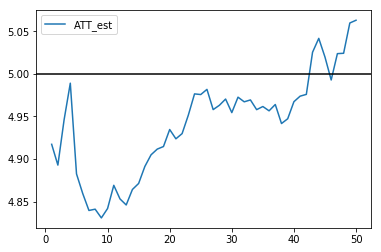

In [18]:
g = pd.DataFrame({'ATT_est': ATT_est}).plot()
g.axhline(y=5, color='black')

In [19]:
ATT_est

0          NaN
1     4.917392
2     4.893011
3     4.946074
4     4.989069
5     4.882674
6     4.859685
7     4.839813
8     4.841315
9     4.831075
10    4.842087
11    4.869311
12    4.853350
13    4.846266
14    4.864420
15    4.871474
16    4.891378
17    4.905077
18    4.911772
19    4.914781
20    4.934739
21    4.923842
22    4.929945
23    4.951560
24    4.976510
25    4.975742
26    4.981806
27    4.958087
28    4.963133
29    4.970456
30    4.954553
31    4.972660
32    4.967219
33    4.969421
34    4.958029
35    4.961709
36    4.956653
37    4.964061
38    4.941748
39    4.947345
40    4.967355
41    4.973851
42    4.975932
43    5.025339
44    5.041621
45    5.019710
46    4.992821
47    5.023706
48    5.024139
49    5.059650
50    5.062870
51         NaN
dtype: float64

Scratch

Removed trend effects

In [20]:
units = 5000 #N
time_steps = 52 #T

p_z = .5
z = np.random.binomial(1, p_z, size=units) #Z

p_d = .25 + z / 2
d = np.random.binomial(1, p_d, size=units) #Causal state

start = np.random.randint(1, 52, size=units) #Start time for causal state
delta = 5 #Treatment effect

#N x T array of causal state over time D_it which stays on for treatment and never activates for control
d_it = np.array([[0] * (start[index]) + [delta] * (52 - start[index]) for index, treatment in enumerate(d)])

# taken from matrix_completion.ipynb
# but removed trend effects
a_trend = np.arange(0, time_steps, 1)
individual_effects = np.random.normal(size=units)
A_indiv = np.tile(individual_effects, time_steps).reshape(time_steps, units).T
Y_0 = A_indiv #Y_0

Y_1 = A_indiv + d_it #Y_1

Y = [Y_0[i] if d[i] == 0 else Y_1[i] for i in range(len(d))] #Y_0 if d == 0 ow Y_1

df = pd.DataFrame(Y)
df['d'] = d
df['Z'] = z
df['start'] = start